In [3]:
!dir ./data/

Parameter format not correct - "data".


In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

from cleaning_scripts import *

# pd.set_option('display.max_rows', None)

In [52]:
basics_df = pd.read_csv('./data/imdb.title.basics.csv.gz')
gross_df = pd.read_csv('./data/bom.movie_gross.csv.gz')
akas_df = pd.read_csv('./data/imdb.title.akas.csv.gz')

# HEADS

In [53]:
print(akas_df.shape)
akas_df.head()

(331703, 8)


,title_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,NaN,NaN,0.0
1,tt0369610,11,Jurashikku warudo,JP,NaN,imdbDisplay,NaN,0.0
2,tt0369610,12,Jurassic World: O Mundo dos Dinossauros,BR,NaN,imdbDisplay,NaN,0.0
3,tt0369610,13,O Mundo dos Dinossauros,BR,NaN,NaN,short title,0.0
4,tt0369610,14,Jurassic World,FR,NaN,imdbDisplay,NaN,0.0


In [54]:
print(gross_df.shape)
gross_df.head()

(3387, 5)


,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [55]:
print(basics_df.shape)
basics_df.head()

(146144, 6)


,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


# MERGES

### Merge basics with akas on title id

In [56]:
# Change tcont to titl_id
basics_df.rename(columns={'tconst': 'title_id'}, inplace=True)

common_id_df = basics_df.merge(akas_df, on='title_id', how='inner')
print(common_id_df.shape)

(331703, 13)


### merge gross with common

In [57]:
gross_df.rename(columns={'title': 'primary_title'}, inplace=True)
final_df = common_id_df.merge(gross_df, on='primary_title', how='inner')
final_df.shape

(54734, 17)

In [47]:
final_df.foreign_gross = pd.to_numeric(final_df.foreign_gross, errors='coerce')
final_df.foreign_gross.fillna(0.0, inplace=True)
final_df.foreign_gross.isna().any()

False

In [11]:
final_df.foreign_gross = pd.to_numeric(final_df.foreign_gross, errors='coerce')
final_df.foreign_gross = final_df.foreign_gross.dropna()

# create total_gross column
final_df['total_gross'] = final_df.domestic_gross + final_df.foreign_gross
# replace na values with the domistic or foreign (whichever is not na)
final_df.total_gross.fillna(final_df.domestic_gross, inplace=True)
final_df.total_gross.fillna(final_df.foreign_gross, inplace=True)

# drop repeated movie listings that resulted in the same total gross
unique_titles_df = final_df.drop_duplicates(subset=['primary_title', 'total_gross'])
# final_df.shape

# print(final_df.domestic_gross.isna().sum())
# print(final_df.foreign_gross.isna().sum())

# PLOTS

### Total Gross by Labeled Genre

Text(0.5, 1.0, 'Total Gross by Top 10 Genres')

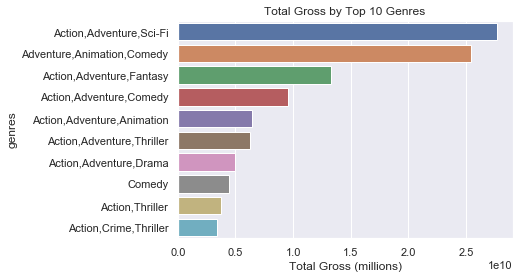

In [12]:
performant_genres = unique_titles_df.groupby("genres").sum().sort_values('total_gross', ascending=False)[0:10]


sns.barplot(data=performant_genres, y=performant_genres.index, x='total_gross', orient='h')

plt.xlabel('Total Gross (millions)')
plt.title("Total Gross by Top 10 Genres")

### Top Genres by Appearance in performant genres

In [13]:
# def parse_genres(genre_series = []):
#     unique_genres = []
#     for g in genre_series:
#         if type(g) == str:
#             for individual_g in g.split(','):
#                 if not individual_g in unique_genres:
#                     unique_genres.append(individual_g)
#     return unique_genres

In [14]:
# def genre_count(genres, df):
#     genre_dict = {}
#     for long_genre in df.genres:
#         for short_genre in genres:
#             if short_genre in long_genre:
#                 if short_genre in genre_dict:
#                     genre_dict[short_genre] += 1
#                 else:
#                     genre_dict[short_genre] = 1
#     return genre_dict

In [36]:
subgenres = get_subgenres(performant_genres.reset_index().genres)
subgenres

['Action',
 'Adventure',
 'Sci-Fi',
 'Animation',
 'Comedy',
 'Fantasy',
 'Thriller',
 'Drama',
 'Crime']

In [39]:
top_subgenres = subgenre_counter(subgenres, performant_genres.reset_index())
top_subgenres

{'Action': 8,
 'Adventure': 7,
 'Sci-Fi': 1,
 'Animation': 2,
 'Comedy': 3,
 'Fantasy': 1,
 'Thriller': 3,
 'Drama': 1,
 'Crime': 1}

Text(0.5, 1.0, 'Subgenre Counts from Top 10 Genres')

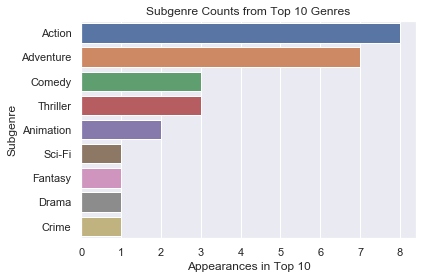

In [37]:

top_genres_df = pd.DataFrame(top_subgenres.items())
top_genres_df.columns = ["Genre", "Count"]
top_genres_df = top_genres_df.sort_values('Count', ascending=False)
sns.barplot(data=top_genres_df, x="Count", y='Genre')
plt.xlabel("Appearances in Top 10")
plt.ylabel("Subgenre")
plt.title("Subgenre Counts from Top 10 Genres")

#### INSIGHTS:

We can plainly see that Action and Adventure genres outperform all other genres by a wide margin. Recommendation is that MS Focus efforts on these genres to maximize impact in the product space.

# PARSING TECH MOVIES

In [17]:
final_df.shape

(54734, 18)

In [48]:
tech_movies = final_df[final_df.attributes.isin(['3-D version', 'IMAX version'])]

top_tech_movies_df = tech_movies.groupby('primary_title').sum().sort_values('total_gross', ascending=False)[0:10]

tech_movies_by_genre_df = tech_movies.groupby('genres').sum().sort_values('total_gross', ascending=False)

top_tech_movies_df.head()


,start_year,runtime_minutes,ordering,is_original_title,domestic_gross,foreign_gross,year,total_gross
primary_title,,,,,,,,
Captain America: Civil War,6048,441.0,71,0.0,1.224300e+09,2.235600e+09,6048,3.459900e+09
Jurassic World,10075,620.0,81,0.0,3.261500e+09,0.000000e+00,10075,3.261500e+09
Zootopia,6048,324.0,52,0.0,1.023900e+09,2.047500e+09,6048,3.071400e+09
Transformers: Dark of the Moon,4022,308.0,40,0.0,7.048000e+08,1.542800e+09,4022,2.247600e+09
Madagascar 3: Europe's Most Wanted,6036,279.0,53,0.0,6.492000e+08,1.591500e+09,6036,2.240700e+09


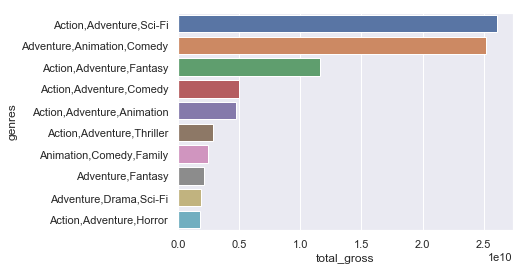

In [19]:
sns.barplot(data=tech_movies_by_genre_df[0:10], x='total_gross', y=tech_movies_by_genre_df[0:10].index)

#### INSIGHTS:

the top genres of the tech movies looks very similar to the top genres overall. Recommendation stands that MS invest in Action and Adventure genres in their visually enhanced movies

Text(0.5, 1.0, 'Top 10 Grossing Movies with Enhanced Visual Element')

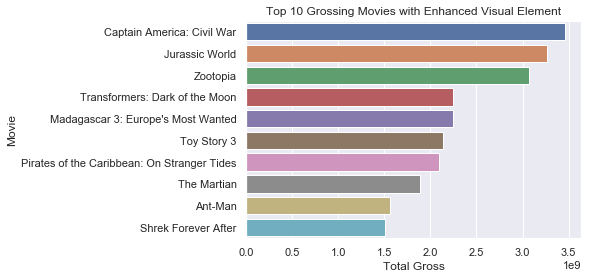

In [20]:
sns.barplot(data=top_tech_movies_df, x='total_gross', y=top_tech_movies_df.index)
plt.ylabel("Movie")
plt.xlabel("Total Gross")
plt.title("Top 10 Grossing Movies with Enhanced Visual Element")

#### INSIGHTS:

This list of top 10 movies with visual enhancements (3D, IMAX) can serve as a model for MS's new studio.

### Getting gross of genres

In [21]:
# get a list of uniue genres
unique_genres = parse_genres(final_df.genres)
genres_df = pd.DataFrame(columns=['genre', 'gross'])



# genres_df = genres_df.append({'genre': 'Action', 'gross': 500}, ignore_index=True)

genres_df.groupby('genre').sum()
# genres_df
# genres_df = pd.DataFrame(parse_genres(genres))
# genres_df.rename(columns={0: 'genre'}, inplace=True)

# genres = final_df.genres

# for i, g in enumerate(genres):
#     simple_genre = genres_df.genre
#     for j, sg in enumerate(simple_genre):
#         if sg in g:
#             print(i, j)

,gross
genre,


In [22]:
final_plot = final_df[(final_df.region == 'US') & (final_df.attributes.isin(['3-D version', 'IMAX version']))].head(33)
final_plot.sort_values('domestic_gross', inplace=True)

final_plot.shape

(33, 18)

In [23]:

final_plot.foreign_gross = pd.to_numeric(final_plot.foreign_gross, errors='coerce')
final_plot.foreign_gross = final_plot.foreign_gross.dropna()

final_plot['total_gross'] = final_plot.domestic_gross + final_plot.foreign_gross
final_plot['first_genre'] = final_plot.genres.apply(lambda x: x.split(',')[0])

# PLOTS (OLD)

### Genre Plot

This plot shows us that, of the 3d and imax movies, action outperforms its nearest competator by nearly 60%. Recommendation - provide technical alternatives (holo lens, xbox, etc.) for action movies to gain a unique place in the product sphere. 

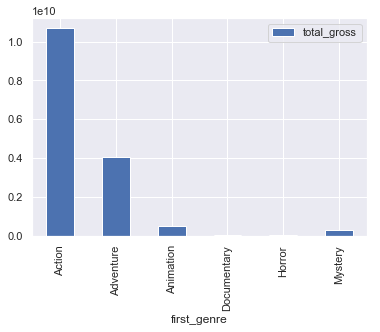

In [24]:
grouped_genres = final_plot.groupby('first_genre').sum()
grouped_genres.plot.bar(y='total_gross')

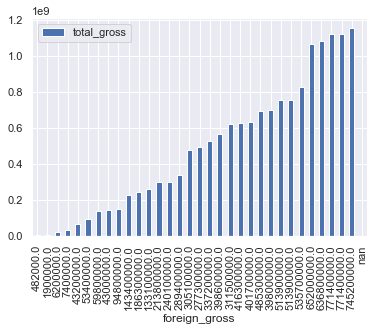

In [25]:

final_plot.sort_values(by='total_gross').plot.bar(x='foreign_gross', y='total_gross')


In [26]:
common_id_df[common_id_df.attributes.isin(['3-D version', 'IMAX version'])]

,title_id,primary_title,original_title,start_year,runtime_minutes,genres,ordering,title,region,language,types,attributes,is_original_title
304,tt0369610,Jurassic World,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",21,Jurassic World 3D,US,NaN,NaN,3-D version,0.0
305,tt0369610,Jurassic World,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",22,Jurassic World 3D,DE,NaN,NaN,3-D version,0.0
306,tt0369610,Jurassic World,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",23,Jurassic World 3D,XWW,NaN,NaN,3-D version,0.0
337,tt0369610,Jurassic World,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",7,Mundo Jurásico,UY,NaN,NaN,3-D version,0.0
338,tt0369610,Jurassic World,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",8,Jurassic World 3D,PL,NaN,NaN,3-D version,0.0
545,tt0401729,John Carter,John Carter,2012,132.0,"Action,Adventure,Sci-Fi",34,John Carter: Entre dos mundos,UY,NaN,NaN,3-D version,0.0
825,tt0433035,Real Steel,Real Steel,2011,127.0,"Action,Drama,Family",6,Real Steel: The IMAX Experience,US,NaN,NaN,IMAX version,0.0
879,tt0435761,Toy Story 3,Toy Story 3,2010,103.0,"Adventure,Animation,Comedy",20,Toy Story 3,UY,NaN,NaN,3-D version,0.0
888,tt0435761,Toy Story 3,Toy Story 3,2010,103.0,"Adventure,Animation,Comedy",29,Toy Story 3: An IMAX 3D Experience,US,NaN,NaN,IMAX version,0.0
1090,tt0448115,Shazam!,Shazam!,2019,132.0,"Action,Adventure,Comedy",2,Shazam!,UY,NaN,NaN,3-D version,0.0


### Merge common_id with gross on primary title

In [27]:
akas_df.attributes.value_counts()
# ['3-D version', 'IMAX version']

new title                               1700
alternative spelling                    1394
literal English title                   1054
complete title                          1034
original subtitled version               879
informal English title                   816
transliterated ISO-LATIN-1 title         695
dubbed version                           645
short title                              640
alternative transliteration              611
DVD box title                            601
literal title                            490
original script title                    300
3-D version                              292
promotional title                        285
informal title                           274
Berlin film festival title               244
long title                               232
poster title                             225
cable TV title                           204
informal literal English title           202
subtitle                                 154
pre-releas

In [28]:
akas_df.types.value_counts()

imdbDisplay         100461
original             44700
working               8680
alternative           6564
festival              3307
dvd                   2995
tv                    1617
video                  121
dvdimdbDisplay          1
festivalworking         1
Name: types, dtype: int64

In [29]:
tech_movies_df = akas_df[akas_df.attributes.isin(['3-D version', 'IMAX version'])]
domestic_tech_movies = tech_movies_df[tech_movies_df.region == 'US']
domestic_tech_movies.shape

(50, 8)

In [32]:
domestic_tech_movies.head()

,title_id,ordering,title,region,language,types,attributes,is_original_title
12,tt0369610,21,Jurassic World 3D,US,NaN,NaN,3-D version,0.0
109,tt1014759,23,Alice in Wonderland: An IMAX 3D Experience,US,NaN,NaN,IMAX version,0.0
1494,tt1869504,3,Jillian's Travels: Africa in 3D,US,NaN,NaN,3-D version,0.0
2586,tt2215719,10,Katy Perry: Part of Me 3D,US,NaN,NaN,3-D version,0.0
2907,tt1104001,12,Tron Legacy: An IMAX 3D Experience,US,NaN,NaN,IMAX version,0.0


In [33]:
domestic_tech_movies.loc[:, ['title', 'title_id', 'region', 'attributes']]

,title,title_id,region,attributes
12,Jurassic World 3D,tt0369610,US,3-D version
109,Alice in Wonderland: An IMAX 3D Experience,tt1014759,US,IMAX version
1494,Jillian's Travels: Africa in 3D,tt1869504,US,3-D version
2586,Katy Perry: Part of Me 3D,tt2215719,US,3-D version
2907,Tron Legacy: An IMAX 3D Experience,tt1104001,US,IMAX version
8290,Inception: The IMAX Experience,tt1375666,US,IMAX version
10828,Real Steel: The IMAX Experience,tt0433035,US,IMAX version
29965,How to Train Your Dragon: An IMAX 3D Experience,tt0892769,US,IMAX version
30356,Immortals 3D,tt1253864,US,3-D version
31895,Get Squirrely 3D,tt2097333,US,3-D version


In [34]:
# for bom.basics
# basics_df.known_for_titles[0].split(',')